In [1]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import glob
import os
from tqdm import tqdm
import pickle
import numpy as np
import cv2
from PIL import Image
from numpy.random import rand, randint, ranf, randn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
from sklearn.model_selection import train_test_split
import numpy.matlib

%matplotlib inline

# データの読み込み、分割

In [2]:
PATH = '../data/training/'
ANNOTATIONS = PATH + "label_2/annotations_list.pkl"
annotations_list = pd.read_pickle("../data/training/label_2/annotations_list.pkl")
annotations_list.head()

,img_name,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,rotation_y
0,004863,Car,0.0,0,-1.55,572.44,181.56,611.95,219.71,1.66,1.73,3.05,-0.82,2.08,33.40,-1.57
1,004863,Tram,0.0,0,-1.48,498.85,149.49,551.40,204.32,3.62,2.60,15.21,-6.27,2.16,55.58,-1.60
2,004863,Car,0.0,1,2.12,56.46,195.89,220.78,260.91,1.47,1.71,4.36,-12.68,2.15,19.71,1.55
3,004863,Car,0.0,0,1.92,321.08,188.65,383.52,221.93,1.52,1.71,3.89,-12.88,2.34,36.20,1.58
4,004863,DontCare,-1.0,-1,-10.00,280.40,183.35,291.90,212.56,-1.00,-1.00,-1.00,-1000.00,-1000.00,-1000.00,-10.00


In [3]:
img_list = list(annotations_list["img_name"].unique())
train_list, val_list = train_test_split(img_list, test_size=0.1, shuffle=True, random_state=0)
print("train_list has", len(train_list), "images.")
print("val_list has", len(val_list), "images.")

train_list has 6732 images.
val_list has 749 images.


# 学習データの作成

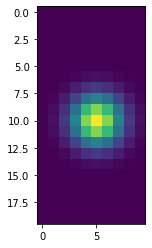

In [4]:
def get_heatmap(h, w, h_center, w_center, sigma=5):
    w_range = np.arange(0,w)-w_center
    w_range = np.matlib.repmat(w_range, h, 1)
    h_range = np.arange(0,h)-h_center
    h_range = h_range.reshape(h,1)
    h_range = np.matlib.repmat(h_range, 1, w)
    Yxyc = np.exp(-(w_range**2+h_range**2)/sigma)
    return Yxyc.T

hm = get_heatmap(10, 20, 5, 10)
plt.imshow(hm)

In [5]:
def line2P(l):
    P_elem = l.split()[1:]
    P = np.array(P_elem, dtype=np.float).reshape(3,-1)
    return P

def readCalib(calib_name, calib_path):
    calib_name = calib_path + calib_name + ".txt"
    with open(calib_name) as f:
        P0 = line2P(f.readline())
        P1 = line2P(f.readline())
        P2 = line2P(f.readline())
        P3 = line2P(f.readline())
        R0_rect = line2P(f.readline())
        Tr_velo_to_cam = line2P(f.readline())
        Tr_imu_to_velo = line2P(f.readline())
    return P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_imu_to_velo

def projectToImage(pts3D, P):
    P = np.array(P)
    
    ones = np.ones([1,pts3D.shape[1]])
    pts3D = np.append(pts3D, ones, axis=0)
    pts2D = np.dot(P, pts3D)
    pts2D[0] /= pts2D[2]
    pts2D[1] /= pts2D[2]
    pts2D = np.delete(pts2D, obj=2, axis=0)
    return pts2D

def selectVisiblePoint(corner3D):
    # 直方体の8点から、隠れた点を除いて出力する
    face_mask = np.array([[1,1,0,0,1,1,0,0], # front
                          [0,1,1,0,0,1,1,0], # left
                          [0,0,1,1,0,0,1,1], # back
                          [1,0,0,1,1,0,0,1]  # right
                         ])

    # 直方体の中心位置を計算
    c_rectangular = np.sum(corner3D, axis=1)/8

    # 各面の法線と面からカメラへの直線がなす角度が90度以下であればその面は見える
    visible_mask = np.zeros(8)
    for i in range(4):
        p_in_plane = corner3D * face_mask[i] # 平面の4つの頂点
        c_plane = np.sum(p_in_plane, axis=1)/4 # 平面の中心
        normal = c_plane - c_rectangular# 平面の法線ベクトル
        c_to_O = -c_plane # 平面の中心からカメラ位置へのベクトル
        if np.dot(c_to_O, normal)>0:
            visible_mask += face_mask[i]
    return corner3D[:,visible_mask!=0]

def compute3Dbb(obj, P):
    face_idx = np.array([[1,2,6,5], # front face
                         [2,3,7,6], # left face
                         [3,4,8,7], # back face
                         [4,1,5,8]]) # right face
    ry = obj["rotation_y"]
    R = np.array([[ np.cos(ry), 0, np.sin(ry)],
                  [          0, 1,          0],
                  [-np.sin(ry), 0, np.cos(ry)]],
                 dtype=np.float)
    l = obj["length"]
    w = obj["width"]
    h = obj["height"]
    corners = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2],
                        [0,0,0,0,-h,-h,-h,-h],
                        [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]],
                       dtype=np.float).reshape(3,-1)
    corner3D = np.dot(R,corners)
    xyz = np.array([obj["x"], obj["y"], obj["z"]], dtype=np.float).reshape([3,1])
    corner3D += xyz # 直方体の各頂点のxyz座標
    
    visible_corner3D = selectVisiblePoint(corner3D) # 見える頂点のみ抽出
    corner2D = projectToImage(visible_corner3D, P) # 画像座標に変換

    return corner2D, face_idx

def getP2(img_name):
    calib_path = "../data/training/calib/"
    _, _, P2, _, _, _, _ = readCalib(img_name, calib_path)
    return P2

def getCorner3D(img_name):
    annotations = annotations_list[annotations_list["img_name"]==img_name]
    _, _, P2, _, _, _, _ = readCalib(img_name, self.calib_path)

    corner3Ds = []
    for _, anno in annotations.iterrows():
        corner3D, face_idx = compute3Dbb(anno, P2)
        corner3Ds.append(corner3D)

    return corner3Ds

In [6]:
RESIZE_SCALE = 4
IMG_WIDTH = 1280 // RESIZE_SCALE
IMG_HEIGHT = IMG_WIDTH // 16 * 5 #400
MODEL_SCALE = 4

def preprocess_image(img):
    #画像サイズを統一
    img_shape = img.shape[0]//RESIZE_SCALE, img.shape[1]//RESIZE_SCALE
    off_x = randint(0, IMG_WIDTH-img_shape[1])
    off_y = randint(0, IMG_HEIGHT-img_shape[0])
    
    img_dummy = np.zeros([IMG_HEIGHT, IMG_WIDTH, 3])
    resize_img = cv2.resize(img, (img_shape[1], img_shape[0]))
    img_dummy[off_y:off_y+img_shape[0], off_x:off_x+img_shape[1]] = resize_img
    return (img_dummy / 255).astype('float32'), (off_x, off_y)

def get_mask_and_regr(img_name, annotations_list, offset=(0,0)):
    
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    mask_cnr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['width', 'height']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 2], dtype='float32')
    
    annotations = annotations_list[annotations_list["img_name"]==img_name]

    P2 = getP2(img_name)
    
    target_type = ['Car', 'Van', 'Truck']

    # annotationを遠い順に並び替え
    annos = []
    for _, anno in annotations.iterrows():
        annos.append(anno)
    annos_sorted = sorted(annos, key=lambda x:x['z'], reverse=True)
    
    for anno in annos_sorted:
        if anno["type"] in target_type:
            ## center pointの学習データを作成 
            # annotationをx, y, width, heightに変換
            x = (anno["left"]+anno["right"])/2 / MODEL_SCALE
            y = (anno["top"]+anno["bottom"])/2 / MODEL_SCALE
            width = (anno["right"]-anno["left"]) / MODEL_SCALE
            height = (anno["bottom"]-anno["top"]) / MODEL_SCALE
            
            x = x / RESIZE_SCALE
            y = y / RESIZE_SCALE
            
            x = np.round(x+offset[0]/ MODEL_SCALE).astype('int')
            y = np.round(y+offset[1]/ MODEL_SCALE).astype('int')
            
            width = width / RESIZE_SCALE
            height = height / RESIZE_SCALE
            
            w = max(width,1)
            h = max(height,1)
            hm = get_heatmap(int(w), int(h), w/2, h/2)
            left = int(x-w/2)
            top = int(y-h/2)

            ## cornerの座標を計算
            cnr, _ = compute3Dbb(anno, P2)
            cnr[0] = (cnr[0]/RESIZE_SCALE + offset[0])//MODEL_SCALE
            cnr[1] = (cnr[1]/RESIZE_SCALE + offset[1])//MODEL_SCALE
            
            # 隠れている車両の正解データを消去
            pts = cv2.convexHull(cnr.T.astype(np.int32))
            cv2.fillConvexPoly(mask, points=pts, color=0)
            cv2.fillConvexPoly(regr[0], points=pts, color=0)
            cv2.fillConvexPoly(regr[1], points=pts, color=0)
            cv2.fillConvexPoly(mask_cnr, points=pts, color=0)

            # x, y, width, heightからmask, regrを作成
            mask[top:top+int(h), left:left+int(w)] = hm
            regr[top:top+int(h), left:left+int(w), 0] = height
            regr[top:top+int(h), left:left+int(w), 1] = width

            ## cornerの学習データを作成
            cnr = cnr.astype(np.int16)
            if w > 5:
                for i in range(8):
                    try:
                        mask_cnr[cnr[1,i],cnr[0,i]] = 1
                    except:
                        pass
    
    return mask, regr, mask_cnr

original image


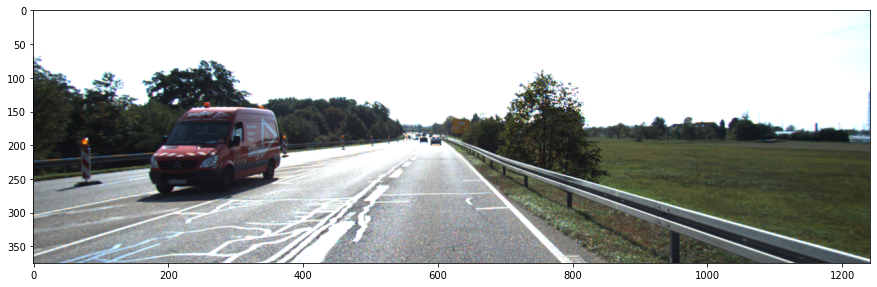

In [7]:
def get_img_path(img_name_list):
    for i in range(len(img_name_list)):
        img_name_list[i] = PATH + "image_2/" + img_name_list[i] + ".png"
        return img_name_list

img_name = train_list[0]
img_name_list = get_img_path([img_name])

print("original image")
img = plt.imread(img_name_list[0])
plt.figure(figsize=(15,8))
plt.imshow(img)

resized image


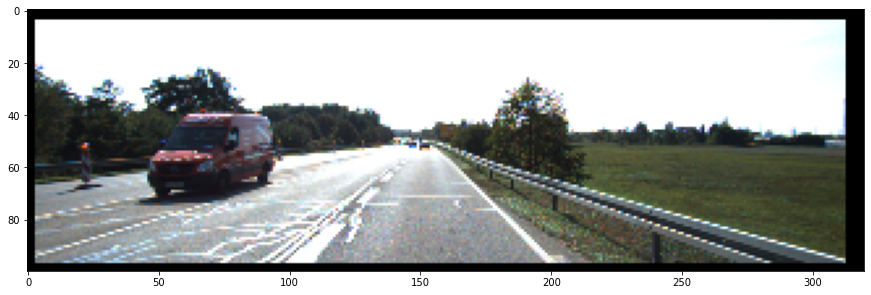

In [8]:
print("resized image")
img, offset = preprocess_image(img)
plt.figure(figsize=(15,8))
plt.imshow(img*255)

vehicle mask
regr
corner mask


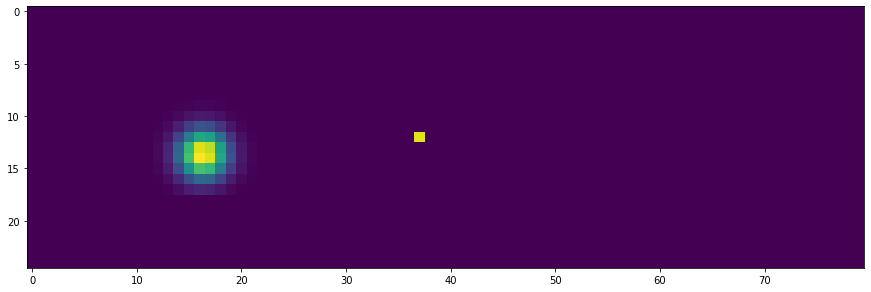

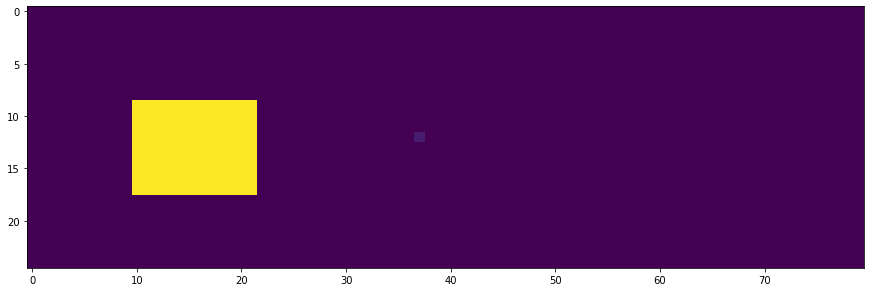

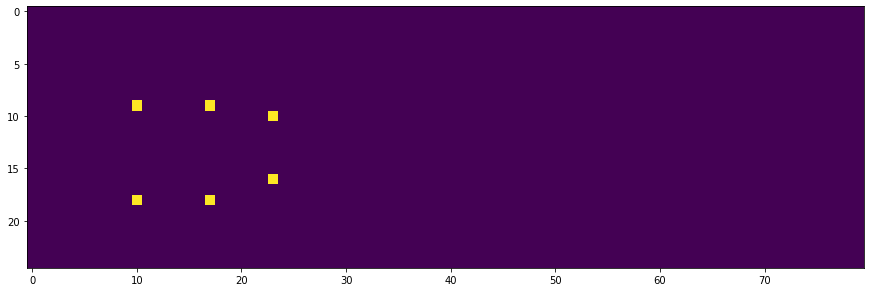

In [9]:
mask, regr, mask_cnr = get_mask_and_regr(img_name, annotations_list, offset)
print("vehicle mask")
plt.figure(figsize=(15,8))
plt.imshow(mask)
print("regr")
plt.figure(figsize=(15,8))
plt.imshow(regr[:,:,1])
print("corner mask")
plt.figure(figsize=(15,8))
plt.imshow(mask_cnr)

# 学習データ生成のためのclassを定義

In [10]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, data_list, annotation, root_dir, training=True):
        self.data_list = data_list
        self.anno = annotation
        self.root_dir = root_dir
        self.training = training
        
        self.anno = pd.read_pickle(ANNOTATIONS)
        

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # Get data
        img_name = self.data_list[idx]
        img_path = self.root_dir + "image_2/" + img_name + ".png"
        img = plt.imread(img_path)
        img, offset = preprocess_image(img)
        mask, regr, mask_cnr = get_mask_and_regr(img_name, self.anno, offset)
        
        # Augmentation
        if self.training:
            fliplr = rand()>.5
            if fliplr:
                img, mask, regr, mask_cnr = img[:,::-1], mask[:,::-1], regr[:,::-1], mask_cnr[:,::-1]
            fliptb = rand()>.5
            if fliptb:
                img, mask, regr, mask_cnr = img[::-1], mask[::-1], regr[::-1], mask_cnr[::-1]
                
        # 配列の向き？を入れ替える
        img = np.rollaxis(img, 2, 0)
        regr = np.rollaxis(regr, 2, 0)
            
        return [img.copy(), mask.copy(), regr.copy(), mask_cnr.copy()]

In [11]:
train_dataset = CarDataset(train_list, annotations_list, PATH, training=True)
val_dataset = CarDataset(val_list, annotations_list, PATH, training=True)

In [12]:
BATCH_SIZE = 16

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# DL Model

In [13]:
from efficientnet_pytorch import EfficientNet

In [14]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [15]:
class EfficientNet_(EfficientNet):
    
    def extract_features_midconv(self, inputs):
        out = []
        
        x = self._swish(self._bn0(self._conv_stem(inputs)))
        
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            y = block(x, drop_connect_rate=drop_connect_rate)
            if y.size()[-1] != x.size()[-1]:
                out.append(x)
            x = y
            
        x = self._swish(self._bn1(self._conv_head(x)))
        out.append(x)
        
        return out[1:]

In [16]:
class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = EfficientNet_.from_pretrained('efficientnet-b0')
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 + 112, 256)
        self.up2 = up(256 + 40, 128)
        self.up3 = up(128 + 24, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        
        x2, x3, x4, x5 = self.base_model.extract_features_midconv(x)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, x5.shape[2], x5.shape[3])
        x5 = torch.cat([x5, mesh2], 1)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.outc(x)
        return x

In [17]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

n_epochs = 40

## MyUNetの出力ベクトル長を設定
model = MyUNet(4).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=0.1,
                              patience=1,
                              verbose=True
                             )
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 4, gamma=0.1)

cpu
Loaded pretrained weights for efficientnet-b0


# Training

In [18]:
lambda_size = 0.1

def criterion(prediction, mask, regr, mask_cnr, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
    # mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:3]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / (mask.sum(1).sum(1) + 1)
    regr_loss = regr_loss.mean(0)
    
    # mask_corner _loss
    pred_mask_cnr = torch.sigmoid(prediction[:, 3])
    mask_cnr_loss = mask_cnr * torch.log(pred_mask_cnr + 1e-12) + (1 - mask_cnr) * torch.log(1 - pred_mask_cnr + 1e-12)
    mask_cnr_loss = -mask_cnr_loss.mean(0).sum()
    
    # Sum
    loss = mask_loss + lambda_size*regr_loss + mask_cnr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss

In [19]:
FINE_TUNE_EPOCH = 10

def train_model(epoch, history=None):
    model.train()
    train_loss = 0
    
    for batch_idx, (img_batch, mask_batch, regr_batch, cnr_batch) in enumerate(tqdm(train_loader)):
            
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        cnr_batch = cnr_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        loss = criterion(output, mask_batch, regr_batch, cnr_batch)
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        loss.backward()
        optimizer.step()
        
        train_loss += train_loss
        
    train_loss /= len(train_loader.dataset)
    
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        #loss.data))
        val_loss.cpu().numpy()))

def evaluate_model(epoch, history=None):
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch, cnr_batch in val_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)
            cnr_batch = cnr_batch.to(device)

            output = model(img_batch)

            val_loss += criterion(output, mask_batch, regr_batch, cnr_batch, size_average=False).data
    
    val_loss /= len(val_loader.dataset)
    scheduler.step(val_loss)
    
    if history is not None:
        history.loc[epoch, 'val_loss'] = val_loss.cpu().numpy()
    
    print('Val loss: {:.4f}'.format(val_loss))

In [20]:
import gc

history = pd.DataFrame()

for epoch in range(n_epochs):
    if epoch == 0:
        print("Base model parameters are FREEZED.")
        for param in model.base_model.parameters():
            param.requires_grad = False
    elif epoch == FINE_TUNE_EPOCH:
        print("Base model parameters are UNFREEZED.")
        for param in model.base_model.parameters():
            param.requires_grad = True
            
    torch.cuda.empty_cache()
    gc.collect()
    train_model(epoch, history)
    evaluate_model(epoch, history)
    torch.save(model.state_dict(), '../models/model_' + str(epoch) + '.pth')

Base model parameters are FREEZED.


100%|██████████| 421/421 [07:50<00:00,  1.12s/it]


Train Epoch: 0 	LR: 0.001000	Loss: 103.847923
Val loss: 188.9593


100%|██████████| 421/421 [07:37<00:00,  1.09s/it]


Train Epoch: 1 	LR: 0.001000	Loss: 147.281891
Val loss: 115.6228


100%|██████████| 421/421 [07:39<00:00,  1.09s/it]


Train Epoch: 2 	LR: 0.001000	Loss: 101.299957
Val loss: 99.4446


100%|██████████| 421/421 [08:35<00:00,  1.22s/it]


Train Epoch: 3 	LR: 0.001000	Loss: 150.029968
Val loss: 93.8239


100%|██████████| 421/421 [08:35<00:00,  1.22s/it]


Train Epoch: 4 	LR: 0.001000	Loss: 90.347076
Val loss: 92.1856


100%|██████████| 421/421 [08:12<00:00,  1.17s/it]


Train Epoch: 5 	LR: 0.001000	Loss: 99.578819
Val loss: 90.3490


100%|██████████| 421/421 [08:14<00:00,  1.17s/it]


Train Epoch: 6 	LR: 0.001000	Loss: 86.909393
Val loss: 87.8606


100%|██████████| 421/421 [07:43<00:00,  1.10s/it]


Train Epoch: 7 	LR: 0.001000	Loss: 104.949142
Val loss: 86.3522


100%|██████████| 421/421 [07:49<00:00,  1.11s/it]


Train Epoch: 8 	LR: 0.001000	Loss: 101.269928
Val loss: 85.3796


100%|██████████| 421/421 [07:56<00:00,  1.13s/it]


Train Epoch: 9 	LR: 0.001000	Loss: 65.133591
Val loss: 85.0227


  0%|          | 0/421 [00:00<?, ?it/s]

Base model parameters are UNFREEZED.


100%|██████████| 421/421 [14:44<00:00,  2.10s/it]


Train Epoch: 10 	LR: 0.001000	Loss: 84.250092
Val loss: 86.9490


100%|██████████| 421/421 [14:35<00:00,  2.08s/it]


Train Epoch: 11 	LR: 0.001000	Loss: 52.539795
Val loss: 83.1330


100%|██████████| 421/421 [14:33<00:00,  2.08s/it]


Train Epoch: 12 	LR: 0.001000	Loss: 90.723434
Val loss: 81.7793


100%|██████████| 421/421 [14:40<00:00,  2.09s/it]


Train Epoch: 13 	LR: 0.001000	Loss: 74.867874
Val loss: 78.2531


100%|██████████| 421/421 [14:53<00:00,  2.12s/it]


Train Epoch: 14 	LR: 0.001000	Loss: 64.779938
Val loss: 87.1309


100%|██████████| 421/421 [14:36<00:00,  2.08s/it]


Train Epoch: 15 	LR: 0.001000	Loss: 101.935562
Val loss: 77.3986


100%|██████████| 421/421 [14:35<00:00,  2.08s/it]


Train Epoch: 16 	LR: 0.001000	Loss: 47.200485
Val loss: 78.0799


100%|██████████| 421/421 [14:41<00:00,  2.09s/it]


Train Epoch: 17 	LR: 0.001000	Loss: 41.459030
Epoch    18: reducing learning rate of group 0 to 1.0000e-04.
Val loss: 80.1500


100%|██████████| 421/421 [14:56<00:00,  2.13s/it]


Train Epoch: 18 	LR: 0.000100	Loss: 74.985847
Val loss: 72.0322


100%|██████████| 421/421 [14:32<00:00,  2.07s/it]


Train Epoch: 19 	LR: 0.000100	Loss: 64.514130
Val loss: 71.6220


100%|██████████| 421/421 [14:35<00:00,  2.08s/it]


Train Epoch: 20 	LR: 0.000100	Loss: 67.949417
Val loss: 71.3391


100%|██████████| 421/421 [14:34<00:00,  2.08s/it]


Train Epoch: 21 	LR: 0.000100	Loss: 109.719604
Val loss: 71.0574


100%|██████████| 421/421 [14:34<00:00,  2.08s/it]


Train Epoch: 22 	LR: 0.000100	Loss: 75.618240
Val loss: 70.5514


100%|██████████| 421/421 [14:33<00:00,  2.07s/it]


Train Epoch: 23 	LR: 0.000100	Loss: 68.725143
Val loss: 71.0681


100%|██████████| 421/421 [14:35<00:00,  2.08s/it]


Train Epoch: 24 	LR: 0.000100	Loss: 51.325829
Epoch    25: reducing learning rate of group 0 to 1.0000e-05.
Val loss: 70.6434


100%|██████████| 421/421 [14:31<00:00,  2.07s/it]


Train Epoch: 25 	LR: 0.000010	Loss: 63.490036
Val loss: 70.6922


100%|██████████| 421/421 [14:34<00:00,  2.08s/it]


Train Epoch: 26 	LR: 0.000010	Loss: 61.039070
Epoch    27: reducing learning rate of group 0 to 1.0000e-06.
Val loss: 70.6677


100%|██████████| 421/421 [14:36<00:00,  2.08s/it]


Train Epoch: 27 	LR: 0.000001	Loss: 71.117157
Val loss: 70.4784


100%|██████████| 421/421 [14:37<00:00,  2.09s/it]


Train Epoch: 28 	LR: 0.000001	Loss: 88.867157
Val loss: 70.5422


100%|██████████| 421/421 [14:31<00:00,  2.07s/it]


Train Epoch: 29 	LR: 0.000001	Loss: 60.630272
Epoch    30: reducing learning rate of group 0 to 1.0000e-07.
Val loss: 70.4977


100%|██████████| 421/421 [14:33<00:00,  2.07s/it]


Train Epoch: 30 	LR: 0.000000	Loss: 77.514549
Val loss: 69.9992


100%|██████████| 421/421 [14:34<00:00,  2.08s/it]


Train Epoch: 31 	LR: 0.000000	Loss: 44.638603
Val loss: 70.4451


100%|██████████| 421/421 [14:36<00:00,  2.08s/it]


Train Epoch: 32 	LR: 0.000000	Loss: 61.317726
Epoch    33: reducing learning rate of group 0 to 1.0000e-08.
Val loss: 70.1849


100%|██████████| 421/421 [14:38<00:00,  2.09s/it]


Train Epoch: 33 	LR: 0.000000	Loss: 64.444923
Val loss: 70.6121


100%|██████████| 421/421 [14:37<00:00,  2.08s/it]


Train Epoch: 34 	LR: 0.000000	Loss: 97.162292
Val loss: 70.4315


100%|██████████| 421/421 [14:38<00:00,  2.09s/it]


Train Epoch: 35 	LR: 0.000000	Loss: 54.089314
Val loss: 70.8781


100%|██████████| 421/421 [14:37<00:00,  2.08s/it]


Train Epoch: 36 	LR: 0.000000	Loss: 54.876915
Val loss: 70.3205


100%|██████████| 421/421 [14:36<00:00,  2.08s/it]


Train Epoch: 37 	LR: 0.000000	Loss: 93.389015
Val loss: 70.0870


100%|██████████| 421/421 [14:34<00:00,  2.08s/it]


Train Epoch: 38 	LR: 0.000000	Loss: 65.680901
Val loss: 70.7168


100%|██████████| 421/421 [14:39<00:00,  2.09s/it]


Train Epoch: 39 	LR: 0.000000	Loss: 117.251129
Val loss: 70.5052


In [21]:
torch.save(model.state_dict(), './model.pth')
model_cpu = model.to('cpu')
torch.save(model_cpu.state_dict(), './model_cpu.pth')

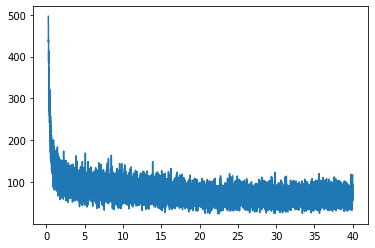

In [22]:
history['train_loss'].iloc[100:].plot()

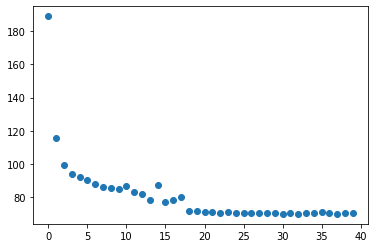

In [23]:
series = history.dropna()['val_loss']
plt.scatter(series.index, series)

In [24]:
m = MyUNet(4)
m.eval()
m_state_dict = torch.load("./model_cpu.pth")
m.load_state_dict(m_state_dict)

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

# Check result

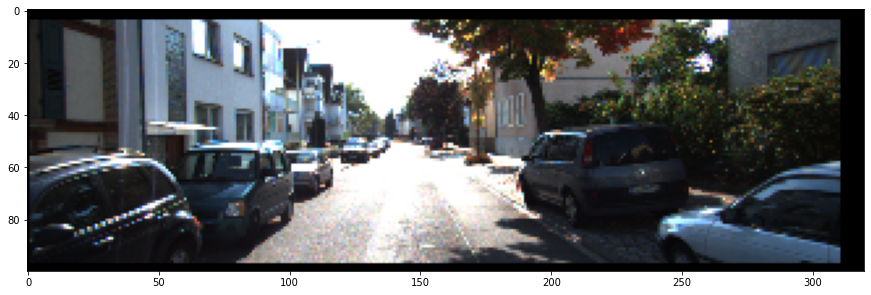

In [32]:
img, mask, regr, cnr = val_dataset[0]
img2 = np.rollaxis(img, 0, 3)
plt.figure(figsize=(15,8))
plt.imshow(img2*255)

In [33]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

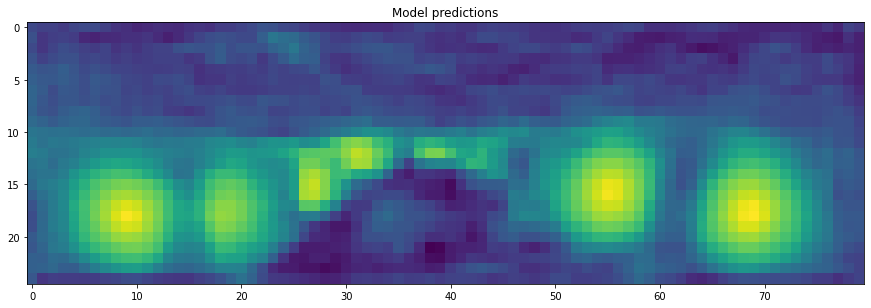

In [34]:
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

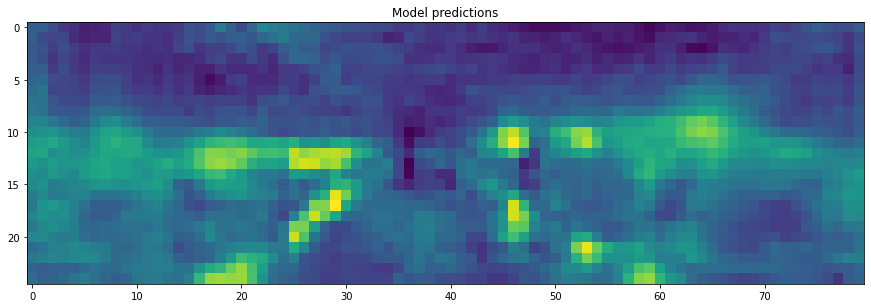

In [35]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,3].data.cpu().numpy()
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()